In [1]:
import uproot
import sys
import site
import glob
import re
import os
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from tqdm.notebook                   import tqdm
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [3]:
run = 1444
run_files = glob.glob(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
#/eos/experiment/wcte/data/2025_commissioning/"+str(run)+"/*.root

# Ordenar los archivos usando extract_p_number
run_files = sorted(run_files, key=extract_p_number)
part_files = [extract_p_number(file) for file in run_files]
len(run_files)

324

In [4]:
def selectec_good_events(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")

    file_hit_card_ids      = tree["hit_mpmt_card_ids"].array()
    file_waveform_card_ids = tree["pmt_waveform_mpmt_card_ids"].array()

    num_hits = np.array([len(h) for h in file_hit_card_ids])
    num_wave = np.array([len(w) for w in file_waveform_card_ids])
    good_mask = (num_hits == num_wave) & (num_hits != 0)

    good_events = np.where(good_mask)[0]

    return good_events

In [5]:
def get_files_from_part(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()

    return file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times

In [6]:
def select_good_parts(parts):
    return [part_file for part_file in tqdm(parts, total=len(parts)) if np.any(uproot.open(run_files[part_file]+":WCTEReadoutWindows")["event_number"].array())]

In [7]:
def create_df_from_file(files):
    cards    = files[0]
    channels = files[1]
    charges  = files[2]
    times    = files[3]

    nevents = len(cards)
    # print('nevents ', nevents)
    evts    = np.arange(nevents)
    nhits   = [len(cards[ievt]) for ievt in evts]
    evt_column = np.repeat(evts, nhits)

    xcards    = ak.flatten(cards)
    xchannels = ak.flatten(channels)
    xcharges  = ak.flatten(charges)
    xtimes    = ak.flatten(times)
    df = pd.DataFrame({'evt':evt_column, 'card':xcards, 'channel':xchannels, 'charge':xcharges, "time":xtimes})
    return df

In [8]:
def df_event_summary(df, ids):
    """ returns a DataFrame with one entry per event and the number of hits and total charge
    for the ids (each id is a pair (card ID, channel ID))
    inputs:
        df   : DataFrame with columns ‘event’, ‘card’, ‘channel’, ‘charge’ (to be extended to time)
        ids  : list of pairs (card, channel) i.e [(0, 0), (0, 1)]
    returns:
        DataFrame with columnes ‘event’ ‘name_of_card_channel_nhits’, ‘name_of_card_channel_charge’
    """
    nevts = np.max(df.evt) + 1
    xdf   = {"evt" : np.arange(nevts)}

    for  id in ids:
        card, channel = id
        sel   = (df.card == card) & (df.channel == channel)
        ievts = df[sel].evt.unique()

        _groups =  df[sel].groupby("evt")
        
        nhits         = _groups.count()["channel"]
        xhits         = np.zeros(nevts, int)
        xhits[ievts]  = nhits
        qtots         = _groups.sum()["charge"]
        xqtots        = np.zeros(nevts, float)
        xqtots[ievts] = qtots
        ttots         = _groups.mean()["time"]
        xttots        = np.zeros(nevts, float)
        xttots[ievts] = ttots

        name = _id_names[(card, channel)]
        xdf[name+"_nhits"]  = xhits
        xdf[name+"_charge"] = xqtots
        xdf[name+"_time"]   = xttots
    
    return pd.DataFrame(xdf)

In [9]:
_id_names = {(130, 0): "ACT0-L", (130, 1): "ACT0-R", (130, 2): "ACT1-L", (130, 3): "ACT1-R", (130, 4): "NC", (130, 5): "ACT2-L",
             (130, 6): "ACT2-R", (130, 7): "ACT3-L", (130, 8): "ACT3-R", (130, 9): "ACT4-L", (130, 10): "ACT4-R", (130, 11): "ACT5-L",
             (130, 12): "ACT5-R", (130, 13): "T1-0L", (130, 14): "T1-0R", (130, 15): "T1-1L", (130, 16): "T1-1R", (130, 17): "HC-0",
             (130, 18): "HC-1", (130, 19): "Trigger",
             (131, 0): "Trigger", (131, 1): "Lemo-1", (131, 2): "Lemo-2", (131, 3): "Lemo-3", (131, 4): "Lemo-4", (131, 5): "Lemo-5",
             (131, 6): "NC", (131, 7): "Lemo-6", (131, 8): "NC", (131, 9): "Laser", (131, 10): "T2", (131, 11): "T3",
             (131, 12): "T0-0L", (131, 13): "T0-1R", (131, 14): "T0-1L", (131, 15): "T0-1R", (131, 16): "NC", (131, 17): "PbG",
             (131, 18): "MuL", (131, 19): "MuR",
             (132, 0): "TOF-0", (132, 1): "TOF-1", (132, 2): "TOF-2", (132, 3): "TOF-3", (132, 4): "TOF-4", (132, 5): "TOF-5",
             (132, 6): "TOF-6", (132, 7): "TOF-7", (132, 8): "TOF-8", (132, 9): "NC", (132, 10): "TOF-9", (132, 11): "TOF-A",
             (132, 12): "TOF-B", (132, 13): "TOF-C", (132, 14): "TOF-D", (132, 15): "TOF-E", (132, 16): "TOF-F", (132, 17): "T4-L",
             (132, 18): "T4-R", (132, 19): "Trigger"}

In [10]:
good_parts = select_good_parts(part_files)

  0%|          | 0/324 [00:00<?, ?it/s]

In [34]:
dfs = []
evt_offset = 0

for ipar in tqdm(good_parts, total=len(good_parts)):
    df = create_df_from_file(get_files_from_part(ipar))
    df['evt'] += evt_offset
    evt_offset = df['evt'].max() + 1  # actualizamos el offset para el siguiente df
    dfs.append(df)

df_concat = pd.concat(dfs, ignore_index=True)

  0%|          | 0/265 [00:00<?, ?it/s]

In [35]:
df_concat.head()

,evt,card,channel,charge,time
0,0,87,11,75.0,2080.676880
1,0,87,12,149.0,2087.733765
2,0,87,10,149.0,2090.839600
3,0,87,4,74.0,2101.392334
4,0,87,11,151.0,4100.148071


In [36]:
df_all = df_event_summary(df_concat, _id_names.keys())
df_all.head()

,evt,ACT0-L_nhits,ACT0-L_charge,ACT0-L_time,ACT0-R_nhits,ACT0-R_charge,ACT0-R_time,ACT1-L_nhits,ACT1-L_charge,ACT1-L_time,...,TOF-E_time,TOF-F_nhits,TOF-F_charge,TOF-F_time,T4-L_nhits,T4-L_charge,T4-L_time,T4-R_nhits,T4-R_charge,T4-R_time
0,0,1,712.0,2240.638672,1,235.0,2239.316650,1,2440.0,2241.186279,...,0.0,0,0.0,0.0,1,821.0,2224.297729,1,513.0,2224.750977
1,1,1,624.0,2242.008057,0,0.0,0.000000,2,3298.0,3005.834351,...,0.0,0,0.0,0.0,1,1123.0,2225.231934,1,652.0,2225.813599
2,2,1,1309.0,2233.266357,1,295.0,2248.804077,1,4001.0,2232.495117,...,0.0,0,0.0,0.0,1,1859.0,2220.365845,1,941.0,2220.851074
3,3,1,3253.0,2239.952637,0,0.0,0.000000,1,1696.0,2237.282593,...,0.0,0,0.0,0.0,1,885.0,2226.638916,1,507.0,2227.205933
4,4,0,0.0,0.000000,1,561.0,2251.066040,1,644.0,2254.043213,...,0.0,0,0.0,0.0,1,1011.0,2225.936523,1,668.0,2226.488647


In [37]:
df_all.to_csv("./df_all.csv");

In [19]:
df_all['ACT_g1_charge'] = df_all['ACT0-R_charge'] + df_all['ACT0-L_charge'] + df_all['ACT1-R_charge'] + df_all['ACT1-L_charge'] +  df_all['ACT3-R_charge'] + df_all['ACT3-L_charge']


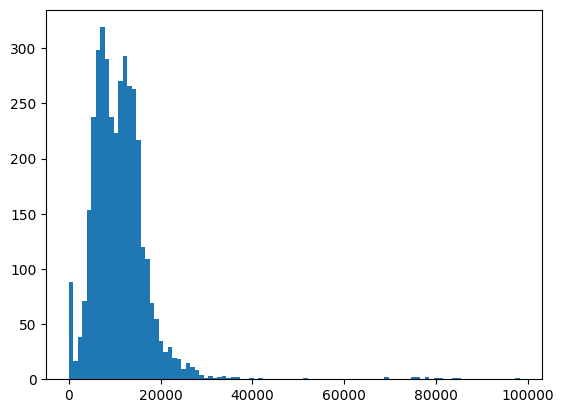

In [22]:
plt.hist(df_all['ACT_g1_charge'], 100);

In [30]:
def plot_monitor_variables(card, channels, variable, return_variables):
    df_monitor = df_event_summary(df_concat, [(card, channels[0]), (card, channels[1])])
    
    if variable == "charge":
        # Charge Plots
        fig = plt.figure()
        left  = df_monitor[_id_names[(card, channels[0])] + "_charge"]
        right = df_monitor[_id_names[(card, channels[1])] + "_charge"]
        plt.hist(left, 100, range=(1,13500), alpha=0.4, label=f"{_id_names[(card, channels[0])]}");
        plt.hist(right, 100, range=(1,13500), alpha=0.4, label=f"{_id_names[(card, channels[1])]}");
        plt.xlabel("Charge Per Event");
        plt.legend(loc="best")
        # Save it
        save_path = f"./figures/{run}/{_id_names[(card, channels[0])]}_and_{_id_names[(card, channels[1])]}_charge.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

    if variable == "time":
        # Time Plots
        fig = plt.figure()
        left  = df_monitor[_id_names[(card, channels[0])] + "_time"]
        right = df_monitor[_id_names[(card, channels[1])] + "_time"]
        plt.hist(left, 100, range=(1,5000), alpha=0.4, label=f"{_id_names[(card, channels[0])]}");
        plt.hist(right, 100, range=(1,5000), alpha=0.4, label=f"{_id_names[(card, channels[1])]}");
        plt.yscale("log");
        plt.xlabel("Time Per Event");
        plt.legend(loc="best")
        # Save it
        save_path = f"./figures/{run}/{_id_names[(card, channels[0])]}_and_{_id_names[(card, channels[1])]}_time.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

    # nHits Plots
    fig = plt.figure()
    plt.hist(df_monitor[_id_names[(card, channels[0])] + "_nhits"], 100, alpha=0.4, label=f"{_id_names[(card, channels[0])]}");
    plt.hist(df_monitor[_id_names[(card, channels[1])] + "_nhits"], 100, alpha=0.4, label=f"{_id_names[(card, channels[1])]}");
    plt.xlabel("nHits Per Event");
    plt.legend(loc="best")
    # Save it
    save_path = f"./figures/{run}/{_id_names[(card, channels[0])]}_and_{_id_names[(card, channels[1])]}_nhits.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)

    # Hist 2D
    fig = plt.figure()
    h = plt.hist2d(df_monitor[_id_names[(card, channels[0])] + "_charge"], df_monitor[_id_names[(card, channels[1])] + "_charge"], bins=(100,100), 
               range=((0, 9000), (0, 11000)), norm="log");
    plt.colorbar(h[3])
    plt.xlabel(_id_names[(card, channels[0])])
    plt.ylabel(_id_names[(card, channels[1])])

    # Save it
    save_path = f"./figures/{run}/{_id_names[(card, channels[0])]}_and_{_id_names[(card, channels[1])]}_2DHits.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)

    if return_variables:
        return left, right


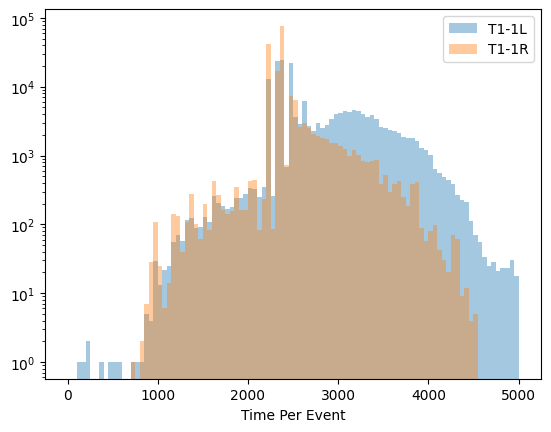

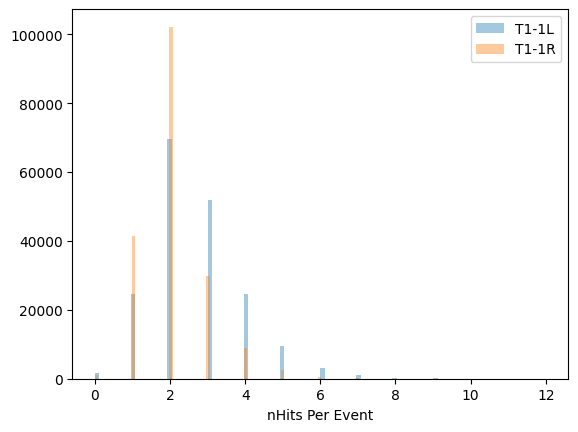

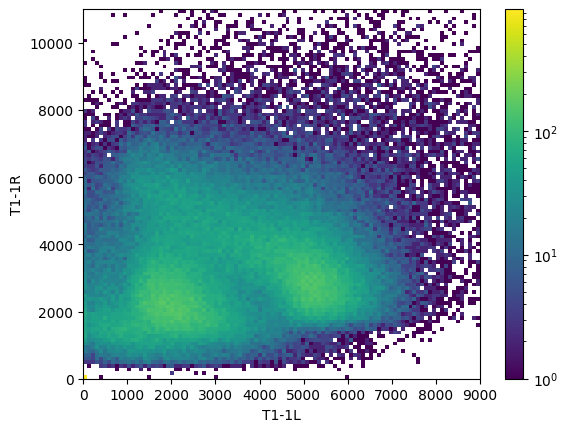

In [32]:
T11L, T11R = plot_monitor_variables(130, [15,16], variable="time", return_variables=True)

In [150]:
def plot_act_group_variables(card, channels):
    left_charge = []
    right_charge = []
    for ic, channel in tqdm(enumerate(channels), total=len(channels)):
        print(f"Reading information for monitors: {_id_names[(card, channel[0])]} and {_id_names[(card, channel[1])]}")
        df_monitor  = df_event_summary(df_concat, [(card, channel[0]), (card, channel[1])])
        left_charge.append(df_monitor[_id_names[(card, channel[0])] + "_charge"].to_numpy())
        right_charge.append(df_monitor[_id_names[(card, channel[1])] + "_charge"].to_numpy())
        
    summed_left_charge = np.sum(left_charge, axis=0)
    summed_right_charge = np.sum(right_charge, axis=0)

    flat_channels_list = [item for sublist in channels for item in sublist]
    numbers = np.unique([int(_id_names[card, i][3]) for i in flat_channels_list])
    group_name = "ACT"+str(numbers[0])+"-"+str(numbers[-1])

    # Charge Plots
    fig = plt.figure()
    plt.hist(summed_left_charge, 100,  range=(1,20500), alpha=0.4, label=f"{group_name}-L");
    plt.hist(summed_right_charge, 100, range=(1,20500), alpha=0.4, label=f"{group_name}-R");
    plt.xlabel("Charge Per Event");
    plt.legend(loc="best")
    # Save it
    save_path = f"./figures/{run}/group_{group_name}_charge.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)

    # Hist 2D
    fig = plt.figure()
    h = plt.hist2d(summed_left_charge, summed_right_charge, bins=(100,100), range=((0, 14000), (0, 18000)), norm="log");
    plt.colorbar(h[3])
    plt.xlabel(group_name+"L")
    plt.ylabel(group_name+"R")

    # Save it
    save_path = f"./figures/{run}/group_{group_name}_2DHits.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)

    return left_charge, right_charge

  0%|          | 0/3 [00:00<?, ?it/s]

Reading information for monitors: ACT0-L and ACT0-R
Reading information for monitors: ACT1-L and ACT1-R
Reading information for monitors: ACT2-L and ACT2-R


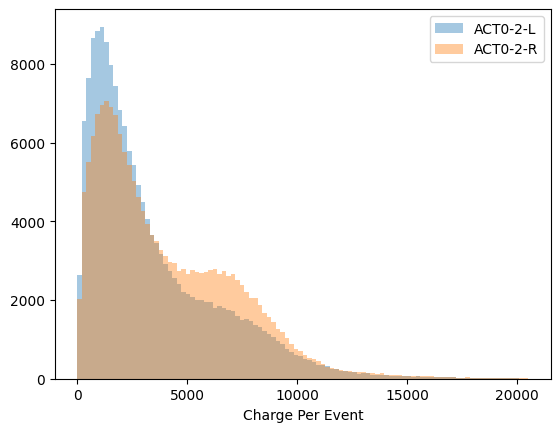

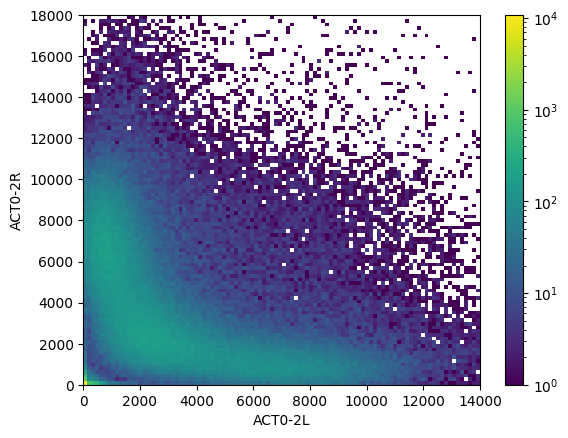

In [151]:
left_charge, right_charge = plot_act_group_variables(130, [[0,1], [2,3], [5,6]])

In [40]:
T1L = [np.mean([i,j]) for (i,j) in zip(T10L, T11L)]
T1R = [np.mean([i,j]) for (i,j) in zip(T10R, T11R)]